# J4_UNID_Expression_Parsing  

** Run these cells one by one. Study the questions and the answers here. **

## You will be provided answers here. 

You'll be provided the answers here. We will tag them as "Free Answer". You will see that only after you run the cells. Write these ** free answers** where indicated in your Assignment.

## Background information for you


Someone was asked to build a calculator following these CFG rules.


```
RULES

Rule 0     S -> expression
Rule 1     expression -> expression PLUS term
Rule 2     expression -> expression MINUS term
Rule 3     expression -> term
Rule 4     term -> term TIMES factor
Rule 5     term -> term DIVIDE factor
Rule 6     term -> factor
Rule 7     factor -> innerfactor EXP factor
Rule 8     factor -> innerfactor
Rule 9     innerfactor -> UMINUS innerfactor
Rule 10    innerfactor -> LPAREN expression RPAREN
Rule 11    innerfactor -> NUMBER
```

They implemented these CFGs in a parser that we shall present in Section 2 below.

## THINGS TO NOTE

* We will use "~" (tilde) for unary minus, and "-" (regular minus) for binary infix minus

* we will use "^" for exponentiation

# The Parser

You may be interested in roughly how abstract CFG rules such as listed above turn into CFG rules as supported by a tool such as PLY.

In [1]:

#----TURN THESE ON IF RUNNING ON JOVE ON COLAB BY REMOVING THE ''' ... '''

'''
! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
import sys
sys.path.append('./Jove')
sys.path.append('./Jove/jove')
'''

#----TURN THESE ON IF RUNNING ON OWN INSTALLATION (default turned-on)

import sys
sys.path[0:0] = ['..',
                 '../3rdparty',
                 '../..',
                 '../../3rdparty',
                 '../../..',
                 '../../../3rdparty',
                 '../../../..',
                 '../../../../3rdparty'
                ] # Put these at the head of the search path

from lex import lex
from yacc import yacc

from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from jove.SystemImports       import *


You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



In [2]:
# Following ideas from http://www.dabeaz.com/ply/example.html heavily
tokens = ('NUMBER','LPAREN','RPAREN','PLUS', 'MINUS', 'TIMES','DIVIDE', 'UMINUS', 'EXP') 

# Tokens
t_PLUS    = r'\+'
t_MINUS   = r'\-'
t_TIMES   = r'\*'
t_DIVIDE  = r'\/'
t_LPAREN  = r'\('
t_RPAREN  = r'\)' 
t_UMINUS  = r'\~' 
t_EXP     = r'\^'

# parsing + semantic actions in one place!
def t_NUMBER(t):
    r'\d+'
    try:
        t.value = int(t.value)
    except ValueError:
        print("Integer value too large %d", t.value)
        t.value = 0
    return t

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)
    

In [3]:

def p_expression_1(t):
    'expression : expression PLUS term'
    #
    t[0] = (t[1][0] + t[3][0],
            attrDyadicInfix("+", t[1][1], t[3][1]))   
    
def p_expression_2(t):
    'expression : expression MINUS term'
    #
    t[0] = (t[1][0] - t[3][0],
            attrDyadicInfix("-", t[1][1], t[3][1]))   
    
def p_expression_3(t):
    'expression : term'
    #
    t[0] = t[1]  
    
# Consult this excellent reference for info on precedences
# https://www.cs.utah.edu/~zachary/isp/worksheets/operprec/operprec.html
    
    
def p_term_1(t):
    'term :  term TIMES factor'
    #
    t[0] = (t[1][0] * t[3][0],
            attrDyadicInfix("*", t[1][1], t[3][1])) 

    
def p_term_2(t):
    'term :  term DIVIDE factor'
    #
    if (t[3][0] == 0):
        print("Error, divide by zero!")
        t[3][0] = 1 # fix it
    t[0] = (t[1][0] / t[3][0],
            attrDyadicInfix("/", t[1][1], t[3][1]))


def p_term_3(t):
    'term :  factor'
    #
    t[0] = t[1]  

def p_factor_1(t):
    'factor : innerfactor EXP factor'
    #
    t[0] = (t[1][0] ** t[3][0],
            attrDyadicInfix("^", t[1][1], t[3][1])) 

def p_factor_2(t):
    'factor : innerfactor'
    #
    t[0] = t[1]
    
def p_innerfactor_1(t):
    'innerfactor : UMINUS innerfactor'
    #
    ast  = ('~', t[2][1]['ast'])
    
    nlin = t[2][1]['dig']['nl']
    elin = t[2][1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("~E_") 
    left = NxtStateStr("~_")

    t[0] =(-t[2][0], 
           {'ast' : ast,
            'dig' : {'nl' : [ root, left ] + nlin, # this order important for proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin) ]
                    }})

    
def p_innerfactor_2(t):
    'innerfactor : LPAREN expression RPAREN'
    #
    ast  = t[2][1]['ast']
    
    nlin = t[2][1]['dig']['nl']
    elin = t[2][1]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(E)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] =(t[2][0],
           {'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], #order important f. proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }})

def p_innerfactor_3(t):
    'innerfactor : NUMBER'
    #
    strn = str(t[1])
    ast  = ('NUMBER', strn)           
    t[0] =(t[1],
           { 'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }})


def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
    
def attrDyadicInfix(op, attr1, attr3):
    ast  = (op, (attr1['ast'], attr3['ast']))
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("E1"+op+"E2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}

#===
# This is the main function in this Jove file.  
#===

def parseExp(s):
    """In: a string s containing a regular expression.
       Out: An attribute triple consisting of
            1) An abstract syntax tree suitable for processing in the derivative-based scanner
            2) A node-list for the parse-tree digraph generated. Good for drawing a parse tree 
               using the drawPT function below
            3) An edge list for the parse-tree generated (again good for drawing using the
               drawPT function below)
    """
    mylexer  = lex()
    myparser = yacc()
    pt = myparser.parse(s, lexer = mylexer)
    
    # print('parsed result  is ', pt)
    # (result, ast, nodes, edges)
    return (pt[0], pt[1]['ast'], pt[1]['dig']['nl'], pt[1]['dig']['el'])

def drawPT(ast_rslt_nl_el, comment="PT"):
    """Given an (ast, nl, el) triple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object.
    """
    (rslt, ast, nl, el) = ast_rslt_nl_el
    
    print("Result calculated = ", rslt)
    print("Drawing AST for ", ast)
    
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

# Now answer these questions

## How does the calculator above parse "\~2^2" ?

Result calculated =  4
Drawing AST for  ('^', (('~', ('NUMBER', '2')), ('NUMBER', '2')))


Generating LALR tables


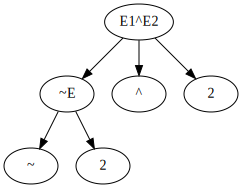

In [4]:
drawPT(parseExp("~2^2"))

** Free answer: ** In our calculator, unary minus has higher precedence than exponentiation, as evidenced by a parse tree of **this many** nodes.  

## Why does Python give a different answer for the expression ```-2**2``` ?

In [5]:
# Python evaluation
-2 ** 2

-4

** Free answer: ** The experiment with the above Python expression shows how our calculator and Python differ. Specifically, the answers are **this one** (calculator) and **this one** (Python). In Python, unary minus binds less tightly than exponentiation.  

## In parsing "2^\~3^\~4", the following parse tree was produced.

How can we tell that the calculator gives higher precedence to "~" (unary minus) and that it right-associates the exponentiation operator?

Result calculated =  1.008594091576999
Drawing AST for  ('^', (('NUMBER', '2'), ('^', (('~', ('NUMBER', '3')), ('~', ('NUMBER', '4'))))))


Generating LALR tables


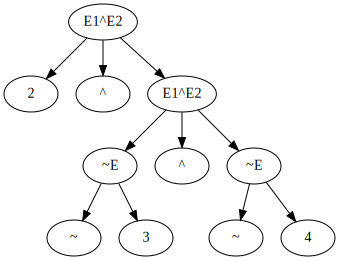

In [6]:
drawPT(parseExp("2^~3^~4"))

** Free answer: ** 

We see how the tree of **this many nodes** for the above expression 2^~3^~4 is built, where the value of the second "^" flows as the EXPONENT of the first "^".  Also see that "~" (the unary minus) is incorporated before any exponentiation gets done.  

## What does ```2**-3**-4``` produce in Python? Is it the same answer?

In [7]:
# The above expression typed into Python in Python's syntax is below, and see what it produces!

2**-3**-4

0.9914791374956781

** Free answer: ** Python differs from our calculator in how it handles ```2**-3**-4``` versus 2^~3^~4. It yields **this answer**.  

## Show by full parenthesization how Python parses 2**-3**-4

In [8]:
2**(-(3**(-4)))

0.9914791374956781

** Free answer: ** 

It parses it as ```2**(-(3**(-4)))```, showing that unary "-" does not have the same precedence as exp. However, the exps are processed right-associatively!

## Parsing ```6*3/4*~5/(2+3-4-5-6/7*~8)-~9```

How many nodes in this parse tree? Same as Python's answer?

Result calculated =  1.1249999999999991
Drawing AST for  ('-', (('/', (('*', (('/', (('*', (('NUMBER', '6'), ('NUMBER', '3'))), ('NUMBER', '4'))), ('~', ('NUMBER', '5')))), ('-', (('-', (('-', (('+', (('NUMBER', '2'), ('NUMBER', '3'))), ('NUMBER', '4'))), ('NUMBER', '5'))), ('*', (('/', (('NUMBER', '6'), ('NUMBER', '7'))), ('~', ('NUMBER', '8')))))))), ('~', ('NUMBER', '9'))))


Generating LALR tables


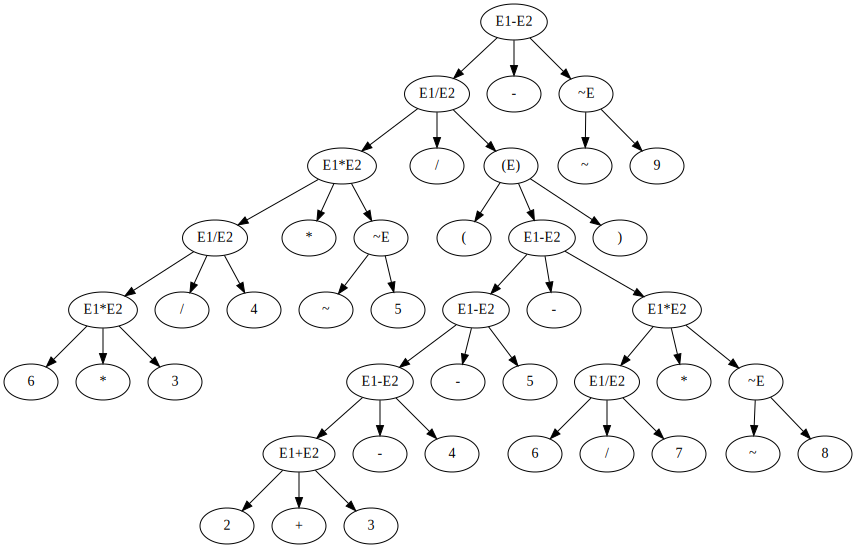

In [9]:
drawPT(parseExp("6*3/4*~5/(2+3-4-5-6/7*~8)-~9"))

In [10]:
# Check against Python!
6*3/4*-5/(2+3-4-5-6/7*-8)--9

1.1249999999999991

** Free Answer: **

* Yes, same answer as Python, which is **this answer**.  
* Over **this many** nodes and below **this many nodes** in the parse tree! 

## How does Python differ from Google Sheets?

With respect to Ref-2,
Point out the similarities and differences between C++, Python, and 
Google Sheets when it comes to handling. Just a few sentences talkingvabout similarities and a few sentences about the differences.
    
- Associativity of exponentiation
- Whether negation or exponentiation is handled first

** Free answer: **

<span style="color: blue">
In `python` and `google-sheets`, the associativity of exponentiation
is **right-associative** and in `c++` its **left associative**
</span>

<span style="color: blue">
**negation** is handled first by `c++` and `google-sheets`
and **exponentiation** is handled first in `python`
</span>